In [2]:
## Compare BETHY monthly NPP with CASA monthly NPP in West Africa from 2014 to 2017

#Import all the required packages
%matplotlib inline
import os
import re
import glob
import pandas as pd
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy import stats
import cftime
import math
import pickle

def read_kml(fname, field=None):
    coords = []
    
    gdf = gpd.read_file(fname, driver='LIBKML')
    if field != None:
        coords = [[row.geometry.x, row.geometry.y, getattr(row, field)] for row in gdf.itertuples(index=True)]
    else:
        coords = [[row.geometry.x, row.geometry.y, idx+1] for idx, row in enumerate(gdf.itertuples(index=True))]
        
    return coords

In [3]:
#Set directory
indir = 'E:\Saiful'
#Import CASA Global NPP data
casa_npp_patt = os.path.join(indir, 'CASA_GFED_data', '*.nc')
casa_npp_lst = glob.glob(casa_npp_patt)
#Filter to keep data from 2014 to 2017
casa_npp_lst_2 = [file for file in casa_npp_lst if re.search(r'.(2014|2015|2016|2017)', file)]
#Open first data layer to inspect
casa_npp_first = xr.open_dataset(casa_npp_lst_2[0])
print(casa_npp_first)

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 12, bounds: 2)
Coordinates:
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 2014-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: bounds
Data variables:
    NPP        (time, latitude, longitude) float32 ...
    Rh         (time, latitude, longitude) float32 ...
    NEE        (time, latitude, longitude) float32 ...
    FIRE       (time, latitude, longitude) float32 ...
    FUEL       (time, latitude, longitude) float32 ...
    time_bds   (time, bounds) datetime64[ns] ...
Attributes: (12/24)
    Conventions:                    CF-1.7
    title:                          2014 GEOS-Carb CASA-GFED3 Monthly Ecosyst...
    source:                         CASA-GFED3 Model using MERRA-2 meteorology
    contact:                        Lesley Ott Lesley.Ott@nasa.g

In [4]:
#open all CASA NPP data
casa_npp_all = xr.open_mfdataset(casa_npp_lst_2, combine='nested', concat_dim = ['time'])

print(casa_npp_all)

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 48, bounds: 2)
Coordinates:
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 2014-01-16T12:00:00 ... 2017-12-16T12:00:00
Dimensions without coordinates: bounds
Data variables:
    NPP        (time, latitude, longitude) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    Rh         (time, latitude, longitude) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    NEE        (time, latitude, longitude) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    FIRE       (time, latitude, longitude) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    FUEL       (time, latitude, longitude) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    time_bds   (time, bounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.nda

In [6]:
## Open the vector data file containing sample points 
#Set the directory of KML file
pts = read_kml(os.path.join(indir, 'BETHY_data', 'bt_africa', 'bt_africa_y', 'westAfrica_casa_pts3.kmz'))
print(pts)

[[4.5701272247065, 7.220695211232735, 1], [9.357573592279554, 5.073654343638358, 2], [-10.94496824232343, 11.61656891756962, 3], [1.739243453566037, 7.147101390054359, 4], [-9.637508356390425, 8.228369064226714, 5], [-9.54059449382756, 10.40335081372953, 6], [5.205059220908026, 9.875697479570679, 7], [9.29524121774936, 9.441090757882632, 8], [-6.528850135684388, 8.386483061610306, 9], [6.745777860699571, 6.690710728996129, 10], [-7.03559479766413, 9.722922117727133, 11], [9.54289959487523, 6.726958926303201, 12], [7.174084260636708, 7.223491849598336, 13], [-10.46360753345283, 6.589874348423368, 14], [-4.852543886473764, 9.909056951249003, 15], [6.347281371756131, 8.082578726883579, 16], [-5.468118559331866, 6.063670431948502, 17], [8.152364520933357, 9.206329248625801, 18], [-14.14543543627267, 10.65916249924607, 19], [0.2824384410115541, 9.20879215584487, 20]]


In [7]:
#create tuple for CASA NPP
tp_casa = []
for p in pts:
    ##extract CASA data and convert from kg to g
    npp_casa = casa_npp_all.NPP.sel(longitude=p[0], latitude=p[1], method='nearest').values * 1000 
    t = casa_npp_all.coords['time'].values
    tp_casa.append([p, t, npp_casa])

#Specify the file path and save the tuple
tuple_file = os.path.join(os.getcwd(), 'tp_casa.pkl')

#save
with open(tuple_file, 'wb') as f:
    pickle.dump(tp_casa, f)

In [8]:
#load the tuple
tuple_file = 'tp_casa.pkl'

with open(tuple_file, 'rb') as f:
    tp_casa = pickle.load(f)

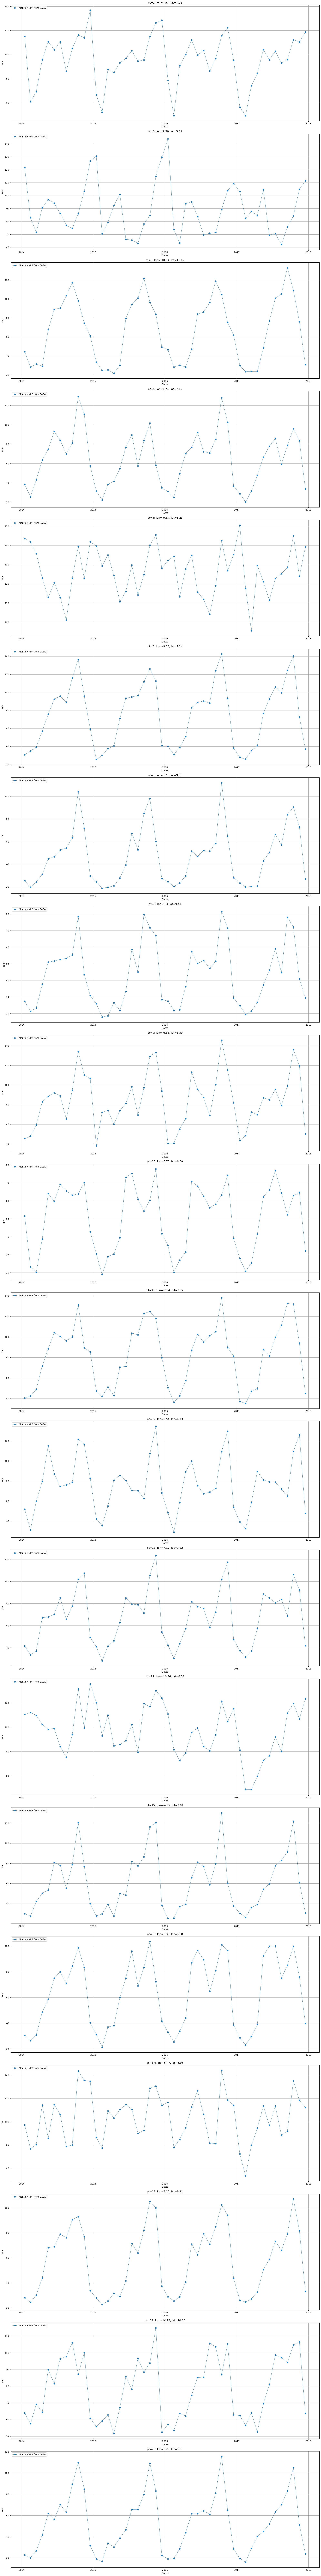

In [11]:
##Plot CASA monthly NPP

fig, axs = plt.subplots(ncols=1, nrows=len(pts), figsize=(20, len(pts)*8))

for idx, ax in enumerate(axs):
    
    ax.plot_date(tp_casa[idx][1], tp_casa[idx][2], 'o-', linewidth=0.7, label='Monthly NPP from CASA')

    ax.set_title('pt={}: lon={}, lat={}'.format(tp_casa[idx][0][2], np.round(tp_casa[idx][0][0],2), np.round(tp_casa[idx][0][1],2)))
    ax.legend(loc='upper left')
    ax.grid()
    
    #years = YearLocator()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.set_xlabel('Dates')
    ax.set_ylabel('NPP')
    
plt.tight_layout() #Adjust the spacing  
plt.show()

In [12]:
##Set the path or file directory for BETHY monthly data
bethy_patt = os.path.join(indir, 'BETHY_data', 'bt_africa', 'bt_africa_m', '*.tif')
lst_bethy = glob.glob(bethy_patt)
#Filter BETHY data from 2014 to 2017
lst_bethy_2 = [file for file in lst_bethy if re.search(r'Y(2014|2015|2016|2017)', file)]
#Open the first data layer
bethy_first = xr.open_dataset(lst_bethy_2[0], engine='rasterio')
print(bethy_first)

<xarray.Dataset>
Dimensions:      (band: 1, x: 3136, y: 1568)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -18.0 -17.99 -17.98 -17.97 ... 9.978 9.987 9.996
  * y            (y) float64 18.0 18.0 17.99 17.98 ... 4.04 4.031 4.022 4.013
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...


In [13]:
##Open BETHY dataset using xarray and combine the datasets
bethy_full = xr.open_mfdataset(lst_bethy_2, combine='nested', concat_dim=['band'])
print(bethy_full)

##Check spatial reference of BETHY
bethy_full.spatial_ref.attrs

<xarray.Dataset>
Dimensions:      (band: 48, x: 3136, y: 1568)
Coordinates:
  * band         (band) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * x            (x) float64 -18.0 -17.99 -17.98 -17.97 ... 9.978 9.987 9.996
  * y            (y) float64 18.0 18.0 17.99 17.98 ... 4.04 4.031 4.022 4.013
    spatial_ref  int32 0
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 1568, 3136), meta=np.ndarray>


{'GeoTransform': '-17.999996133070944 0.008928570769521927 0.0 18.00891355626743 0.0 -0.008928573370592016'}

In [14]:
## Create a tuple for bethy data
tp_bethy = []
for p in pts:
    npp_bethy = bethy_full.band_data.sel(x=p[0], y=p[1], method='nearest').values
    t = casa_npp_all.coords['time'].values
    tp_bethy.append([p, t, npp_bethy])

#Specify the file path and save the tuple
tuple_file = os.path.join(os.getcwd(), 'tp_bethy.pkl')

#save
with open(tuple_file, 'wb') as f:
    pickle.dump(tp_bethy, f)

In [15]:
#load the tuple
tuple_file = 'tp_bethy.pkl'

with open(tuple_file, 'rb') as f:
    tp_bethy = pickle.load(f)

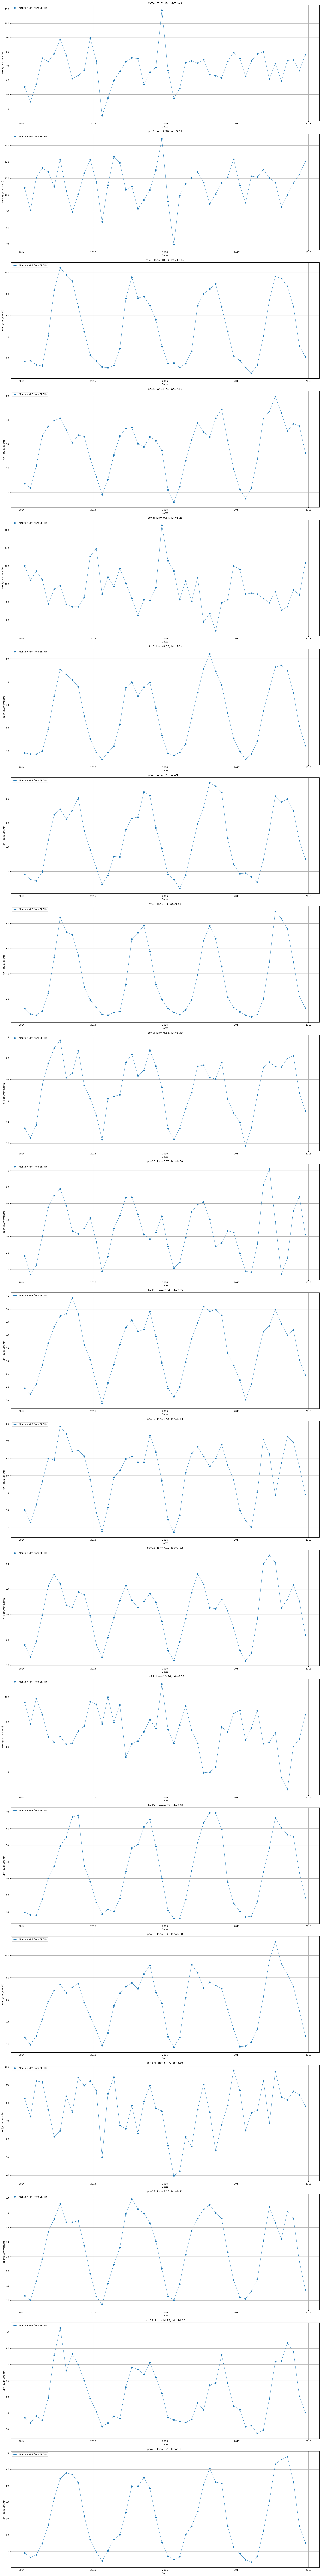

In [16]:
#Plot BETHY
fig, axs = plt.subplots(ncols=1, nrows=len(pts), figsize=(20, len(pts)*8))

for idx, ax in enumerate(axs):
    
    ax.plot_date(tp_bethy[idx][1], tp_bethy[idx][2], 'o-', linewidth=0.8, label='Monthly NPP from BETHY')
    
    # Set title and legend
    ax.set_title('pt={}: lon={}, lat={}'.format(tp_bethy[idx][0][2], np.round(tp_bethy[idx][0][0],2), np.round(tp_bethy[idx][0][1],2)))
    ax.legend(loc='upper left')
    ax.grid()
    
    # Set x-axis and axis label
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel('Dates')
    ax.set_ylabel('NPP (gC/m²/month)')
    
# Show the plots
plt.tight_layout()
plt.show()

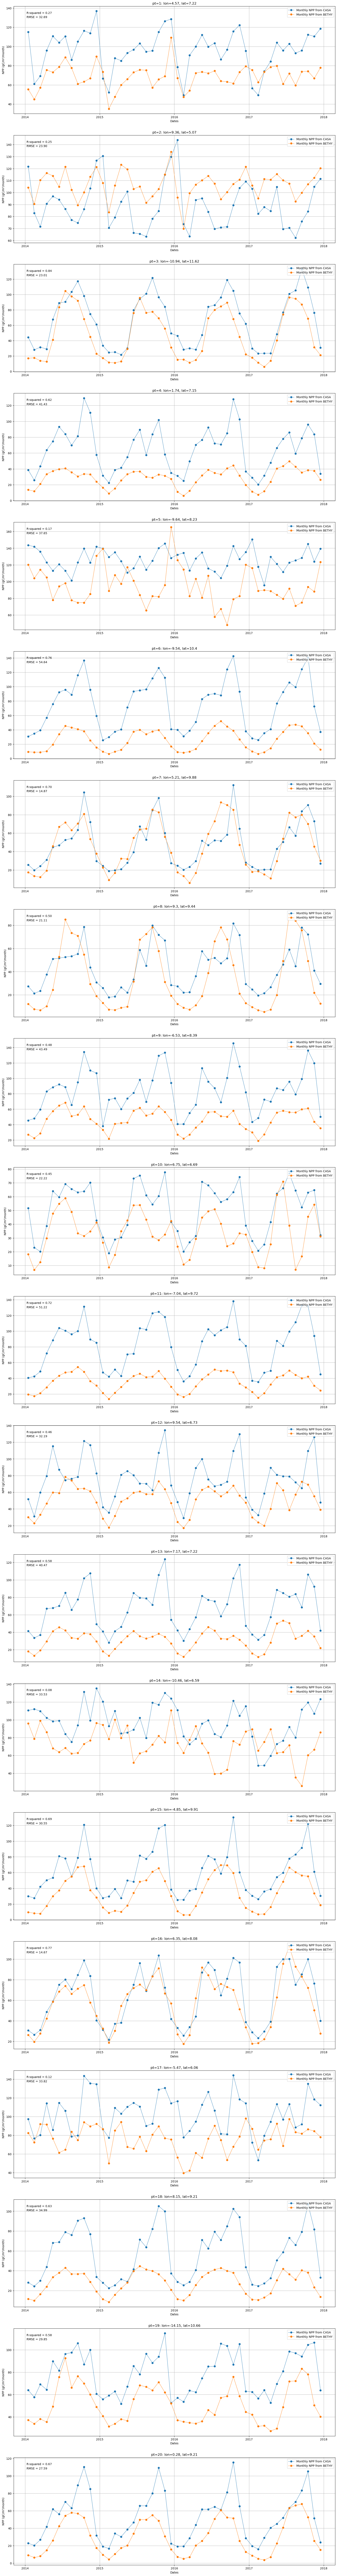

In [17]:
#Plot BETHY and CASA data together and calculate correlation and RMSE statistics

fig, axs = plt.subplots(ncols=1, nrows=len(pts), figsize=(20, len(pts)*8))

for idx, ax in enumerate(axs):
    
    #Plot MODIS GPP
    ax.plot_date(tp_casa[idx][1], tp_casa[idx][2], 'o-', linewidth=0.8, label='Monthly NPP from CASA')
    ax.plot_date(tp_bethy[idx][1], tp_bethy[idx][2], 'o-', linewidth=0.8, label='Monthly NPP from BETHY')
    
    # Set title and legend
    ax.set_title('pt={}: lon={}, lat={}'.format(tp_bethy[idx][0][2], np.round(tp_bethy[idx][0][0],2), np.round(tp_bethy[idx][0][1],2)))
    ax.legend(loc='upper right')
    ax.grid()
    
    # Calculate Pearson correlation and R-squared
    npp_casa = np.array(tp_casa[idx][2])
    npp_bethy = np.array(tp_bethy[idx][2])
    correlation = stats.pearsonr(npp_casa, npp_bethy)[0]
    r_squared = correlation ** 2

    # Add R-squared value to the plot
    ax.text(0.04, 0.93, f'R-squared = {r_squared:.2f}', transform=ax.transAxes)
    
    #Estimate RMSE
    MSE = np.square(np.subtract(npp_casa,npp_bethy)).mean()
    RMSE = math.sqrt(MSE)
    #Add RMSE on the plot
    ax.text(0.04, 0.89, f'RMSE = {RMSE:.2f}', transform=ax.transAxes)
    
    #Set x-axis and axis label
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel('Dates')
    ax.set_ylabel('NPP (gC/m²/month)')
    
#Show the plots
#plt.tight_layout()
plt.show()